In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

r = requests.get('https://www.andamen.com/collections/shop-all-andamen?_fsView=grid-3&_fsPage=1')
soup = BeautifulSoup(r.content, 'html.parser')

# Find all <a> tags with the class "all-products-link"
all_product_links = soup.find_all('a')
links = []

In [2]:
# Fetching all links of collections
for urls in all_product_links:
    href = urls.get('href')
    links.append(href)

# Search for the word "/collections/" in the links 
search_word = "/collections/"
found_links = [link for link in links if link is not None and search_word in link]

In [3]:
# Filtering list items which start with 'https'
links = [item for item in found_links if 'https' in item]
links
# List to store all filtered URLs
Bundle=[]

In [4]:
for i in links:
    url = f"{i}"
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    script_tags = soup.find_all('script', type='application/json')
    try:
        for script_tag in script_tags:
            try :
                if 'money_format' in script_tag.get('sa-money-format'):
                    money_format_data = script_tag.string
            except:
                money_format_data = "None"
    except: 
        "Not Found"
    all_products_data = re.search(r'var allProducts = (.*?)\;', r.text)
    if all_products_data:
        all_products_data = all_products_data.group(1)
        all_products_data = re.sub(r'([a-zA-Z_]+):', r'"\1":', all_products_data)
        pattern = r'\{.*?\}'
        dictionary_strings = re.findall(pattern, all_products_data, re.DOTALL)
        list_of_dictionaries = [eval(dictionary) for dictionary in dictionary_strings]
        Bundle = Bundle + list_of_dictionaries

In [5]:
df = pd.DataFrame(Bundle)

In [6]:
df = df.drop('name', axis=1)

# Drop duplicate rows 
df = df.drop_duplicates(keep="first").reset_index(drop=True)

In [7]:
df = df.rename(columns = {'title':'Title','id':'Id', 'price':'Price', 'brand':'Brand', 'category':'Category', 'variant':'Variant','productId':'Product_Id','variantId':'Variant_Id', 'handle':'Handle'})

In [8]:
# Split the 'Id' column from the right by hyphen delimiter and provide custom column names
split_columns1 = df['Id'].str.rsplit('-', n=3, expand=True)

# Rename the columns with custom names
split_columns1.columns = ['Collection', 'Specific Color', 'Si', 'Ty']

# Add the split columns back to the original DataFrame
df = pd.concat([df, split_columns1], axis=1)

In [9]:
# Cleaning data to replace errors with right data
idx = (df['Title'] == 'Dark Indigo')
df.loc[idx] = df.loc[idx].rename(columns={'Color':'Si','Si':'Color'})

In [10]:
idx = (df['Title'] == 'Creamy White Shirt')
df.loc[idx] = df.loc[idx].rename(columns={'Color':'Si','Si':'Color'})

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
# Split the Variant Column to extract Color, Size, Type
# Split the 'Id' column from the right by hyphen delimiter and provide custom column names
split_columns2 = df['Variant'].str.split('\/', n=2, expand=True)

# Rename the columns with custom names
split_columns2.columns = ['Color', 'Size', 'Type']

# Add the split columns back to the original DataFrame
df = pd.concat([df, split_columns2], axis=1)

In [13]:
# Drop unnecessary columns
df=df.drop(['Si','Ty'], axis=1)

In [14]:
# Replacing delimiter '\' with space.
df['Color'] = df['Color'].str.replace(r'\\' , '' , regex=True)
df['Size'] = df['Size'].str.replace(r'\\' , '' , regex=True)

In [15]:
df['Color'].replace('412', 'Dark Navy', inplace = True)

In [16]:
# Faster Parser than BeautifulSoup for parsing 
from selectolax.parser import HTMLParser

In [18]:
# Extraction of Material data and subtitles of products
Composition = []
s_title = []
for i in df['Handle']:
    url = f"https://www.andamen.com/products/{i}"
    r = requests.get(url)
    html = r.text
    parser = HTMLParser(html)
    fabric_span = parser.css('div.col-9 h6 > p')    
    product_subtitle = parser.css('h6.product-subtitle > p')
    if fabric_span:
        fabric_text = fabric_span[0].text()        
        print(fabric_text, )
    else:
        "Not Found"
    Composition.append(fabric_text)
    if product_subtitle:
        subtitle = product_subtitle[0].text()
    else:
        subtitle = "Not Found"
    s_title.append(subtitle)

100% Cotton
100% Cotton
100% cotton
100% Linen
100% Cotton
100% Cotton
100% Cotton
100% Cotton
100% Cotton
100% Cotton
100% Cotton
100% Cotton
100% Cotton
100% Cotton
98/2 Cotton lycra
100% Cotton
100% Cotton
100% Cotton
100% Cotton (Shankar 6)
100% Linen
100% Cotton
100% Cotton (Shankar 6)
98/2 Cotton lycra
100% Linen
100% Cotton
100% Cotton
100% Linen
100% Linen
100% Linen
100% Linen
100% Linen
100% Linen
100% Linen
100% Linen
100% Linen
100% Linen
100% Linen
Cotton Lycra
Cotton Lycra
Cotton Lycra
Cotton
Cotton Lycra
Cotton Wool Blend
Cotton
Cotton
Cotton
Linen
Cotton Lycra
Cotton
Cotton
Cotton
Cotton
Cotton
Cotton
Cotton
Cotton
Cotton
Cotton
Cotton
Cotton Polyester
Cotton Polyester
Cotton Polyester
Cotton Polyester
Cotton
Cotton
Cotton Wool Blend
Cotton Wool Blend
Cotton Wool Blend
Cotton
Cotton Wool Blend
Cotton Wool Blend
Cotton Wool Blend
Cotton Wool Blend
Cotton
Cotton
100% Linen
Cotton
100% Linen
Cotton Wool Blend
100% Cotton
100% Cotton
Cotton
Cotton
Wool
100% Linen
Cotton Woo

In [19]:
df['Subtitle'] = s_title
df['Composition'] = Composition

In [20]:
# Replacing errors in data
offwhite = r'Offwhite|Off white|OffWhite'
df['Specific Color'] = df['Specific Color'].str.replace(offwhite , 'Off White' , regex=True)
df['Specific Color'] = df['Specific Color'].str.replace('Biege', 'Beige' , regex=True)
df['Specific Color'] = df['Specific Color'].str.replace('Lavendar', 'Lavender' , regex=True)
df['Specific Color'] = df['Specific Color'].str.replace('Sage' , 'Sage Green' , regex=True)

In [21]:
df['Color'] = df['Color'].str.replace(offwhite , 'Off White' , regex=True)
df['Color'] = df['Color'].str.replace('Other ' , 'Rust ' , regex=True)
df['Color'] = df['Color'].str.replace('412 ' , 'Dark Navy' , regex=True)
df['Color'] = df['Color'].str.replace('Sage' , 'Green' , regex=True)

In [22]:
# Function to remove repetitive values in Material
def extract_material(text):
    parts = [part for part in text.split() if part.isalpha()]
    return '-'.join(parts)

df['Material'] = df['Composition'].apply(extract_material)

In [23]:
df['Material'] = df['Material'].str.title()

In [24]:
aggregation = r'Compact-Cotton|Giza-Cotton'
df['Material'] = df['Material'].str.replace(aggregation , 'Cotton' , regex=True)

In [25]:
df['Category'].replace('', 'Shirt', inplace = True)

In [26]:
df = df.drop('Variant_Id', axis=1)

In [29]:
df.to_csv('Andamen2.csv')

In [30]:
# Data Visualization
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()
data = pd.read_csv('Andamen2.csv')

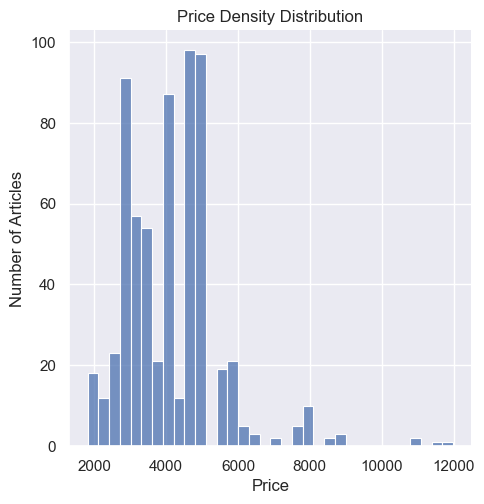

In [31]:
# Density of articles in different price ranges
# This chart shows us that most articles are in approximate prices of 3000, 4000 & 5000.
bin_width = 300
sns.displot(data, x='Price', binwidth=bin_width, kde=False)
plt.xlabel('Price')
plt.ylabel('Number of Articles')
plt.title('Price Density Distribution')
plt.show()

Text(0, 0.5, 'Material')

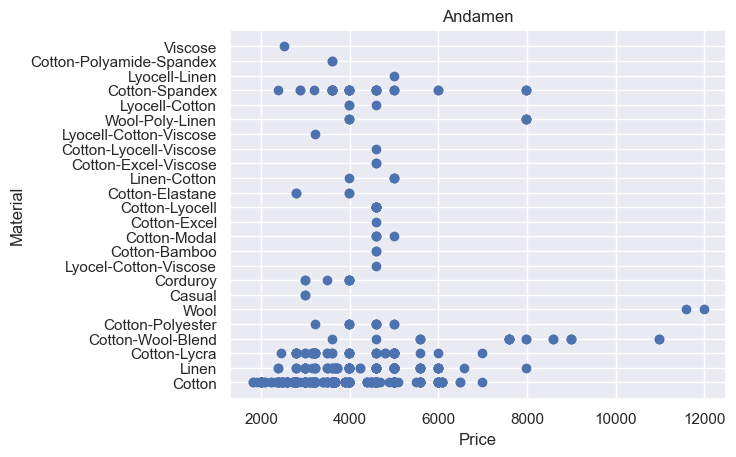

In [34]:
# create a figure and axis
fig, ax = plt.subplots()

# scatter the sepal_length against the sepal_width
ax.scatter(data['Price'], data['Material'])
# set a title and labels
ax.set_title('Andamen')
ax.set_xlabel('Price')
ax.set_ylabel('Material')

<Axes: xlabel='Material'>

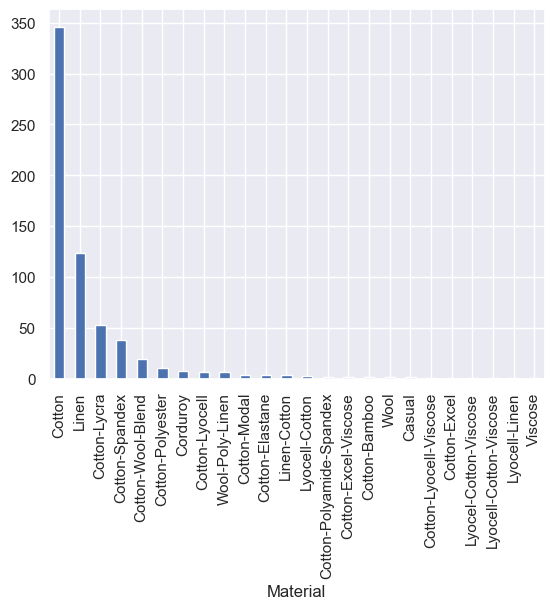

In [35]:
data.groupby('Material').Title.count().sort_values(ascending=False)[:30].plot.bar()

In [33]:

from sqlalchemy import create_engine

# Define your database connection
# Replace 'your_database' with the name of your database and 'your_table' with the name of your table
engine = create_engine('sqlite:///your_database.db')

# Export the DataFrame to a SQL table
data.to_sql('your_table', con=engine, if_exists='replace', index=False)

# Close the database connection
engine.dispose()
